# How to make an LGBM model


In [1]:
from pathlib import Path

import geopandas as gpd
import ray
import requests
import shapely

from eolearn.core import FeatureType

### Preparations

In [2]:
# establish project folder where all the files are saved
PROJECT_FOLDER = Path("./lulc_project")

In [3]:
# download reference data
REFERENCE_PATH = PROJECT_FOLDER / "input-data" / "reference.gpkg"
REFERENCE_PATH.parent.mkdir(parents=True, exist_ok=True)

url = "http://eo-learn.sentinel-hub.com.s3.eu-central-1.amazonaws.com/land_use_10class_reference_slovenia_partial.gpkg"
r = requests.get(url, allow_redirects=True)
with open(REFERENCE_PATH, "wb") as gpkg:
    gpkg.write(r.content)

In [4]:
# establish AOI and TOI
reference_gdf = gpd.read_file(REFERENCE_PATH)

aoi_bounds = reference_gdf.total_bounds
aoi_geometry = shapely.geometry.box(*aoi_bounds)
aoi_gdf = gpd.GeoDataFrame(geometry=[aoi_geometry], crs=reference_gdf.crs)

TOI = ["2019-01-01", "2019-12-31"]

In [5]:
# save to geojson
aoi_gdf.to_file(PROJECT_FOLDER / "input-data" / "aoi.geojson")

### Define project specifics

In [6]:
RESOLUTION = 10  # 10m resolution
BAND_NAMES = ["B02", "B03", "B04", "B08", "B11", "B12"]  # same subset as in eo-learn


area_config = {
    "manager": "eogrow.core.area.UtmZoneAreaManager",
    "geometry_filename": "aoi.geojson",
    "patch": {"size_x": 10000, "size_y": 10000},  # EOPatches will be 10km x 10km, which is 1000px x 1000px
}
logging_config = {
    "manager": "eogrow.core.logging.LoggingManager",
    "save_logs": True,  # save logs in a dedicated folder
    "show_logs": True,  # show logs in CLI/notebook so we can see progress
}
storage_config = {
    "manager": "eogrow.core.storage.StorageManager",
    "project_folder": str(PROJECT_FOLDER),  # where all the files are stored
    "structure": {  # key: path pairs for identifying subfolders. Here we have a very simple structure
        "downloaded_data": "data/imagery",
        "mosaicked_data": "data/mosaicked",
        "reference": "reference",
        "samples": "samples/eopatches",
        "merged_samples": "samples/merged",
        "models": "models",
        "predictions": "predictions",
    },
}

managers = {  # every pipeline needs these, so we pack them together to pass them in with the ** notation
    "area": area_config,
    "storage": storage_config,
    "logging": logging_config,
}

### Initialize cluster

In [7]:
ray.init(num_cpus=4)  # restrict number of CPUS to avoid memory issues

2024-03-14 07:47:43,705	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.10
Ray version:,2.6.3
Dashboard:,http://127.0.0.1:8265


## Download and process imagery

In [8]:
from eogrow.pipelines.download import DownloadPipeline

download_config = dict(
    **managers,
    output_folder_key="downloaded_data",
    bands_feature_name="BANDS",
    bands=BAND_NAMES,
    additional_data=[(FeatureType.MASK, "CLM"), (FeatureType.MASK, "dataMask")],
    data_collection="SENTINEL2_L2A",
    resolution=RESOLUTION,
    maxcc=0.2,
    time_period=TOI,
    use_dn=True,
    threads_per_worker=4,  # to avoid overloading SH
)

download_pipeline = DownloadPipeline.from_raw_config(download_config)

In [9]:
download_pipeline.run()

 INFO [07:47:45] eogrow.core.pipeline:234: Running DownloadPipeline
 INFO [07:47:45] eogrow.core.area.utm:53: Splitting area geometry into UTM zone grid
 INFO [07:47:45] eogrow.core.area.base:114: Saving grid to cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-03-14 07:47:46,110	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.10:64745...
2024-03-14 07:47:46,110	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [07:47:46] eogrow.core.pipeline:180: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:12:42] eogrow.core.pipeline:204: RayExecutor finished with 12 / 12 success rate
 INFO [08:12:43] eogrow.core.pipeline:213: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T06-47-45Z-DownloadPipeline-046752db15/eoexecution-report-2024_03_14-07_47_46/report.html
 INFO [08:12:43] eogrow.core.pipeline:243: Pipeline finished successfully!


We want to remove any invalid points in the data series and make it uniform. For that `eo-grow` offers mosaicking. We also calculate the NDVI in this step.

In [10]:
from eogrow.pipelines.features import MosaickingFeaturesPipeline

mosaicking_config = dict(
    **managers,
    input_folder_key="downloaded_data",
    bands_feature_name="BANDS",
    output_folder_key="mosaicked_data",
    output_feature_name="FEATURES",
    data_preparation=dict(
        cloud_mask_feature_name="CLM",
        valid_data_feature_name="dataMask",
        validity_threshold=0.8,  # discard any time-frames with not enough suitable data
    ),
    ndis=dict(NDVI=[BAND_NAMES.index("B08"), BAND_NAMES.index("B04")]),
    mosaicking=dict(time_period=TOI, n_mosaics=12),  # make a 'per-month' mosaic
)

mosaicking_pipeline = MosaickingFeaturesPipeline.from_raw_config(mosaicking_config)

In [11]:
mosaicking_pipeline.run()

 INFO [08:12:43] eogrow.core.pipeline:234: Running MosaickingFeaturesPipeline
 INFO [08:12:43] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-03-14 08:12:43,688	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.10:64745...
2024-03-14 08:12:43,689	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [08:12:43] eogrow.core.pipeline:180: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:14:12] eogrow.core.pipeline:204: RayExecutor finished with 12 / 12 success rate
 INFO [08:14:12] eogrow.core.pipeline:213: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T07-12-43Z-MosaickingFeaturesPipeline-002b9e39e6/eoexecution-report-2024_03_14-08_12_43/report.html
 INFO [08:14:12] eogrow.core.pipeline:243: Pipeline finished successfully!


## Reference data

In [12]:
from eogrow.pipelines.rasterize import RasterizePipeline

rasterization_config = dict(
    **managers,
    input_folder_key="input_data",
    output_folder_key="reference",
    vector_input="reference.gpkg",
    output_feature=(FeatureType.MASK_TIMELESS, "LULC"),
    raster_values_column="lulcid",
    resolution=RESOLUTION,
    no_data_value=0,
)

rasterization_pipeline = RasterizePipeline.from_raw_config(rasterization_config)

In [13]:
rasterization_pipeline.run()

 INFO [08:14:13] eogrow.core.pipeline:234: Running RasterizePipeline
 INFO [08:14:13] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-03-14 08:14:13,145	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.10:64745...
2024-03-14 08:14:13,145	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [08:14:13] eogrow.core.pipeline:180: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:14:19] eogrow.core.pipeline:204: RayExecutor finished with 12 / 12 success rate
 INFO [08:14:19] eogrow.core.pipeline:213: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T07-14-13Z-RasterizePipeline-8f930c9d63/eoexecution-report-2024_03_14-08_14_13/report.html
 INFO [08:14:19] eogrow.core.pipeline:243: Pipeline finished successfully!


## Sampling data for model

In [14]:
from eogrow.pipelines.sampling import FractionSamplingPipeline

rasterization_config = dict(
    **managers,
    output_folder_key="samples",
    apply_to={
        "mosaicked_data": {"data": ["FEATURES"]},
        "reference": {"mask_timeless": ["LULC"]},
    },
    seed=42,
    sampling_feature_name="LULC",
    fraction_of_samples=0.5,  # sample 50% of suitable data
    exclude_values=[0],  # do not sample pixels which are marked as no-data
)

sampling_pipeline = FractionSamplingPipeline.from_raw_config(rasterization_config)

In [15]:
sampling_pipeline.run()

 INFO [08:14:19] eogrow.core.pipeline:234: Running FractionSamplingPipeline
 INFO [08:14:19] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-03-14 08:14:19,386	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.10:64745...
2024-03-14 08:14:19,387	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [08:14:19] eogrow.core.pipeline:180: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:14:37] eogrow.core.pipeline:204: RayExecutor finished with 12 / 12 success rate
 INFO [08:14:37] eogrow.core.pipeline:213: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T07-14-19Z-FractionSamplingPipeline-00f3d708e8/eoexecution-report-2024_03_14-08_14_19/report.html
 INFO [08:14:37] eogrow.core.pipeline:243: Pipeline finished successfully!


## Training the model

In [16]:
from eogrow.pipelines.merge_samples import MergeSamplesPipeline

merging_config = dict(
    **managers,
    input_folder_key="samples",
    output_folder_key="merged_samples",
    features_to_merge=[("data", "FEATURES"), ("mask_timeless", "LULC")],
)

merge_pipeline = MergeSamplesPipeline.from_raw_config(merging_config)

In [17]:
merge_pipeline.run()

 INFO [08:14:37] eogrow.core.pipeline:234: Running MergeSamplesPipeline
 INFO [08:14:37] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg
 INFO [08:14:37] eogrow.pipelines.merge_samples:62: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:14:45] eogrow.pipelines.merge_samples:85: EOExecutor finished with 12 / 12 success rate
 INFO [08:14:45] eogrow.pipelines.merge_samples:89: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T07-14-37Z-MergeSamplesPipeline-df92b73d7a/eoexecution-report-2024_03_14-08_14_37/report.html
 INFO [08:14:45] eogrow.pipelines.merge_samples:112: Started merging feature (<FeatureType.DATA: 'data'>, 'FEATURES')
 INFO [08:14:46] eogrow.pipelines.merge_samples:166: Saved concatenated array to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/samples/merged/FEATURES.npy
 INFO [08:14:46] eogrow.pipelines.merge_samples:112: Started merging feature (<FeatureType.MASK_TIMELESS: 'mask_timeless'>, 'LULC')
 INFO [08:14:46] eogrow.pipelines.merge_samples:166: Saved concatenated array to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/samples/merged/LULC.npy
 INFO [08:14:46] eogrow.core.pipeline:243: Pipeline finished

In [18]:
from eogrow.pipelines.training import ClassificationTrainingPipeline

merging_config = dict(
    **managers,
    input_folder_key="merged_samples",
    model_folder_key="models",
    model_filename="lulc_model",
    train_features=["FEATURES.npy"],
    train_reference="LULC.npy",
    train_test_split=dict(train_size=0.8),  # keep 20% of data to evaluate model
)

training_pipeline = ClassificationTrainingPipeline.from_raw_config(merging_config)

In [19]:
training_pipeline.run()

 INFO [08:14:47] eogrow.core.pipeline:234: Running ClassificationTrainingPipeline
 INFO [08:14:47] eogrow.pipelines.training:84: Preparing data
 INFO [08:14:47] eogrow.pipelines.training:111: Reading input features
 INFO [08:14:47] eogrow.pipelines.training:122: Reading input reference
 INFO [08:14:47] eogrow.pipelines.training:137: Making a random train-test split, using 0.8 of data for training.
 INFO [08:14:48] eogrow.pipelines.training:87: Training. This could take a while.
 INFO [08:16:56] eogrow.pipelines.training:90: Saving.
 INFO [08:16:56] eogrow.pipelines.training:166: Saving to lulc_model
 INFO [08:16:56] eogrow.pipelines.training:93: Scoring results.
 INFO [08:16:59] eogrow.pipelines.training:242: Accuracy:	 0.8358
 INFO [08:16:59] eogrow.pipelines.training:243: F1 score:	 0.8301
 INFO [08:16:59] eogrow.pipelines.training:244: Recall:	 0.8358
 INFO [08:16:59] eogrow.pipelines.training:245: Precision:	 0.8278
 INFO [08:16:59] eogrow.core.pipeline:243: Pipeline finished succe

## Sanity check

In [20]:
from eogrow.pipelines.prediction import ClassificationPredictionPipeline

merging_config = dict(
    **managers,
    input_folder_key="mosaicked_data",
    input_features=[("data", "FEATURES")],
    output_folder_key="predictions",
    output_feature_name="predicted_LULC",
    model_folder_key="models",
    model_filename="lulc_model",
)

prediction_pipeline = ClassificationPredictionPipeline.from_raw_config(merging_config)

In [21]:
prediction_pipeline.run()

 INFO [08:16:59] eogrow.core.pipeline:234: Running ClassificationPredictionPipeline
 INFO [08:16:59] eogrow.core.area.base:102: Loading grid from cache/UtmZoneAreaManager_aoi_10000_10000_0.0_0.0_0.0_0.0.gpkg


2024-03-14 08:16:59,512	INFO worker.py:1431 -- Connecting to existing Ray cluster at address: 192.168.1.10:64745...
2024-03-14 08:16:59,512	INFO worker.py:1453 -- Calling ray.init() again after it has already been called.


 INFO [08:16:59] eogrow.core.pipeline:180: Starting processing for 12 EOPatches


  0%|          | 0/12 [00:00<?, ?it/s]

 INFO [08:19:16] eogrow.core.pipeline:204: RayExecutor finished with 12 / 12 success rate
 INFO [08:19:17] eogrow.core.pipeline:213: Saved EOExecution report to /home/zluksic/Documents/Projects/eo-grow/examples/lulc_project/logs/2024-03-14T07-16-59Z-ClassificationPredictionPipeline-4c1f5599f6/eoexecution-report-2024_03_14-08_16_59/report.html
 INFO [08:19:17] eogrow.core.pipeline:243: Pipeline finished successfully!


In [22]:
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

from eolearn.core import EOPatch

patch_name = "eopatch-id-05-col-1-row-1"

ref_patch = EOPatch.load(PROJECT_FOLDER / "reference" / patch_name)
predicted_patch = EOPatch.load(PROJECT_FOLDER / "predictions" / patch_name)
reference = ref_patch.mask_timeless["LULC"]
prediction = predicted_patch.mask_timeless["predicted_LULC"]

In [23]:
colors = [
    "#ffffff",
    "#ffff00",
    "#054907",
    "#ffa500",
    "#806000",
    "#069af3",
    "#95d0fc",
    "#967bb6",
    "#dc143c",
    "#a6a6a6",
    "#000000",
]
lulc_cmap = ListedColormap(colors, name="lulc_cmap")
lulc_norm = BoundaryNorm([x - 0.5 for x in range(11)], lulc_cmap.N)

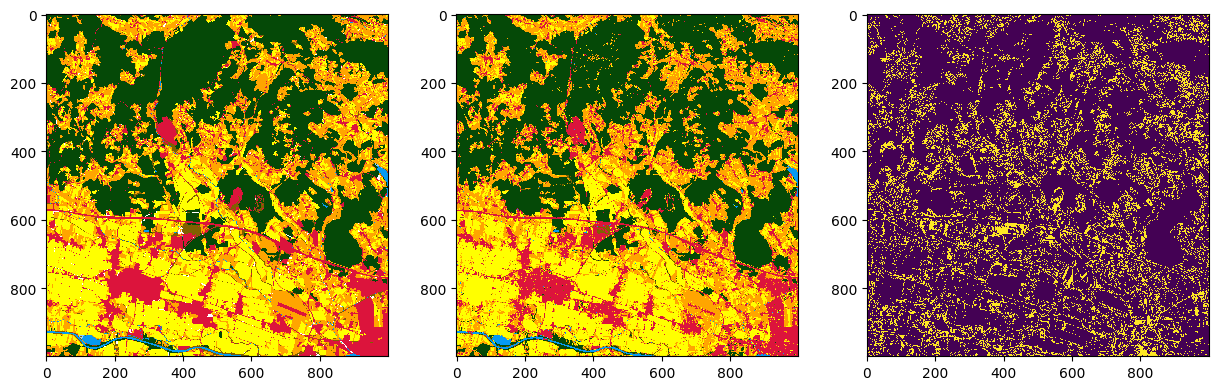

In [24]:
figs, axs = plt.subplots(1, 3, figsize=(15, 6))
axs[0].imshow(reference, cmap=lulc_cmap, norm=lulc_norm, interpolation="none")
axs[1].imshow(prediction, cmap=lulc_cmap, norm=lulc_norm, interpolation="none")
axs[2].imshow(reference != prediction, interpolation="none")